In [1]:
#imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#data
from dataset import ONRData

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from imblearn.over_sampling import SMOTE
from dataset import ONRData
from collections import Counter

# Convert PyTorch dataset to numpy arrays for SMOTE
def dataset_to_numpy(dataset):
    data = []
    labels = []
    for i in range(len(dataset)):
        x, y = dataset[i]  # Assuming (features, label) format
        data.append(x.numpy())  # Convert to NumPy
        labels.append(y)
    return np.array(data), np.array(labels)

# Convert numpy arrays back to a PyTorch dataset
class CustomTensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)  # Ensure long dtype for classification
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Load dataset
data = ONRData(label_dtype='int')

# Split into train and test sets
# Split based on group data.groups
# Split dataset into groups
group_indices = data.groups  # Group IDs for each sample
unique_groups = np.unique(group_indices)

# Shuffle groups
np.random.shuffle(unique_groups)

# 80-20 split on unique groups
split_ratio = 0.8
train_groups = unique_groups[:int(split_ratio * len(unique_groups))]
test_groups = unique_groups[int(split_ratio * len(unique_groups)):]

# Create train and test indices based on group membership
train_indices = [i for i, group in enumerate(group_indices) if group in train_groups]
test_indices = [i for i, group in enumerate(group_indices) if group in test_groups]

# Debugging prints
print(f"Total Unique Groups: {len(unique_groups)}")
print(f"Train Groups: {len(train_groups)}, Test Groups: {len(test_groups)}")
print(f"Total Samples: {len(group_indices)}")
print(f"Train Samples: {len(train_indices)}, Test Samples: {len(test_indices)}")

# Verify no group overlap
overlap = set(train_groups) & set(test_groups)
if overlap:
    print(f"Warning: Overlapping groups found: {overlap}")
else:
    print("✅ No overlapping groups between train and test sets.")


# Create train and test datasets based on group membership
train_indices = [i for i, group in enumerate(group_indices) if group in train_groups]
test_indices = [i for i, group in enumerate(group_indices) if group in test_groups]

train_data = torch.utils.data.Subset(data, train_indices)
test_data = torch.utils.data.Subset(data, test_indices)

# Extract features and labels from train_data
X_train, y_train = dataset_to_numpy(train_data)



# Count class distribution
class_counts = Counter(y_train)
max_count = max(class_counts.values())

# Oversample minority classes
X_resampled = []
y_resampled = []

for class_label, count in class_counts.items():
    # Get indices of samples for the current class
    class_indices = np.where(y_train == class_label)[0]
    # Calculate how many more samples are needed
    num_to_add = max_count - count
    # Duplicate samples to balance the class
    oversampled_indices = np.random.choice(class_indices, num_to_add, replace=True)
    X_resampled.append(X_train[class_indices])
    X_resampled.append(X_train[oversampled_indices])
    y_resampled.extend([class_label] * (count + num_to_add))

# Concatenate oversampled data
X_resampled = np.concatenate(X_resampled, axis=0)
y_resampled = np.array(y_resampled)

# Convert back to PyTorch Dataset
train_data_smote = CustomTensorDataset(X_resampled, y_resampled)

# Create DataLoaders
train_loader = DataLoader(train_data_smote, batch_size=32, shuffle=True)  # No need for WeightedRandomSampler
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


print("Class distribution after oversampling:", np.bincount(y_resampled))


23
23
23
Total Unique Groups: 23
Train Groups: 18, Test Groups: 5
Total Samples: 4405
Train Samples: 3415, Test Samples: 990
✅ No overlapping groups between train and test sets.
Class distribution after oversampling: [2870 2870]


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class fNIRS_CNN_LSTM(nn.Module):
    def __init__(self, in_channels=4, num_classes=1, dropout_rate=0.5):
        super(fNIRS_CNN_LSTM, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Add batch normalization
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)  # Changed kernel to 3x3
        self.bn2 = nn.BatchNorm2d(32)  # Add batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout layer with configurable rate
        self.dropout = nn.Dropout(dropout_rate)
        
        # LSTM Layer with bidirectional option
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, batch_first=True, bidirectional=True)
        
        # Fully Connected Layers (adjusted for bidirectional LSTM)
        self.fc1 = nn.Linear(128 * 2, 64)  # Doubled input size for bidirectional
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        # Reshape for LSTM - calculate dimensions dynamically
        batch_size, channels, height, width = x.size()
        # Reshape to (batch, seq_len, features)
        x = x.permute(0, 2, 3, 1)  # [batch, height, width, channels]
        x = x.reshape(batch_size, height * width, channels)  # [batch, seq_len, features]
        
        # LSTM layer
        x, _ = self.lstm(x)
        # Get final output from both directions
        x = x[:, -1, :]
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Additional dropout before final layer
        
        # For multi-class classification use softmax, for binary use sigmoid
        if self.fc2.out_features > 1:
            x = F.log_softmax(self.fc2(x), dim=1)
        else:
            x = torch.sigmoid(self.fc2(x))
        
        return x

# Configuration
def train_fnirs_model(batch_size=64, learning_rate=0.0001, num_epochs=50, early_stopping_patience=10):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {device}")
    
    # Model initialization
    model = fNIRS_CNN_LSTM(in_channels=4, num_classes=1, dropout_rate=0.5).to(device)
    
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Print model summary
    print(model)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    
    return model, criterion, optimizer, scheduler, device



In [4]:
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler, device, 
                num_epochs=50, early_stopping_patience=10, checkpoint_dir='checkpoints'):
    """
    Training function for fNIRS CNN-LSTM model
    
    Args:
        model: The neural network model
        dataloaders: Dictionary with 'train' and 'val' dataloaders
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Computing device (CPU/GPU)
        num_epochs: Maximum number of training epochs
        early_stopping_patience: Number of epochs to wait before early stopping
        checkpoint_dir: Directory to save model checkpoints
    
    Returns:
        model: Best model weights
        history: Training history
    """
    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        
    # Initialize variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    no_improve_epochs = 0
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': [],
        'lr': []
    }
    
    # Training timer
    start_time = time.time()
    
    print(f"Starting training on {device}...")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^9} | {'Time':^9}")
    print("-" * 65)
    
    # Training loop
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass - track gradients only during training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    # Get predictions for accuracy calculation
                    preds = (outputs > 0.5).float()
                    
                    
                    # Calculate loss
                    
                    labels = labels.to(torch.float32)  # Ensure labels are float for BCELoss
                    loss = criterion(outputs.flatten(), labels)
                    
                    # Backward pass + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        # Gradient clipping to prevent exploding gradients
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            # Calculate epoch metrics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            
            # Store history for plots
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                history['lr'].append(optimizer.param_groups[0]['lr'])
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
                # Update learning rate scheduler based on validation loss
                scheduler.step(epoch_loss)
                
                # Save the model if validation loss improved
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    no_improve_epochs = 0
                    
                    # Save checkpoint
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'loss': best_loss,
                        'accuracy': epoch_acc
                    }, os.path.join(checkpoint_dir, f'fnirs_model_epoch_{epoch}_loss_{best_loss:.4f}.pt'))
                else:
                    no_improve_epochs += 1
        
        # Calculate time elapsed for the epoch
        epoch_time = time.time() - epoch_start
        
        # Print epoch statistics
        print(f"{epoch+1:^7} | {history['train_loss'][-1]:^12.6f} | {history['train_acc'][-1]:^10.4f} | "
              f"{history['val_loss'][-1]:^10.6f} | {history['val_acc'][-1]:^9.4f} | {epoch_time:^9.2f}s")
        
        # Early stopping check
        if no_improve_epochs >= early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs. No improvement for {early_stopping_patience} epochs.")
            break
    
    # Calculate total training time
    total_time = time.time() - start_time
    print(f"\nTraining complete in {total_time//60:.0f}m {total_time%60:.0f}s")
    print(f"Best validation loss: {best_loss:.6f}")
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate model performance on test set
    
    Args:
        model: Trained model
        test_loader: DataLoader for test set
        criterion: Loss function
        device: Computing device
    
    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs).flatten()
           
            labels = labels.to(torch.float32)  # Ensure labels are float for BCELoss
            loss = criterion(outputs, labels)
            
            # Get predictions
            preds = (outputs > 0.5).float()
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            running_loss += loss.item() * inputs.size(0)
    
    # Calculate metrics
    test_loss = running_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Print results
    print("\nTest Set Evaluation:")
    print(f"Loss: {test_loss:.6f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    return {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }



Using device: cuda


c:\Users\Alex\anaconda3\envs\workload\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


fNIRS_CNN_LSTM(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(32, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
Number of parameters: 203425
Starting training on cuda...
 Epoch  |  Train Loss  | Train Acc  |  Val Loss  |  Val Acc  |   Time   
-----------------------------------------------------------------
   1    |   0.693411   |   0.4990   |  0.696156  |  0.2788   |   2.15   s
   2    |   0.692167   |   0.5188   |  0.693801  |  0.4717   |   1.72 

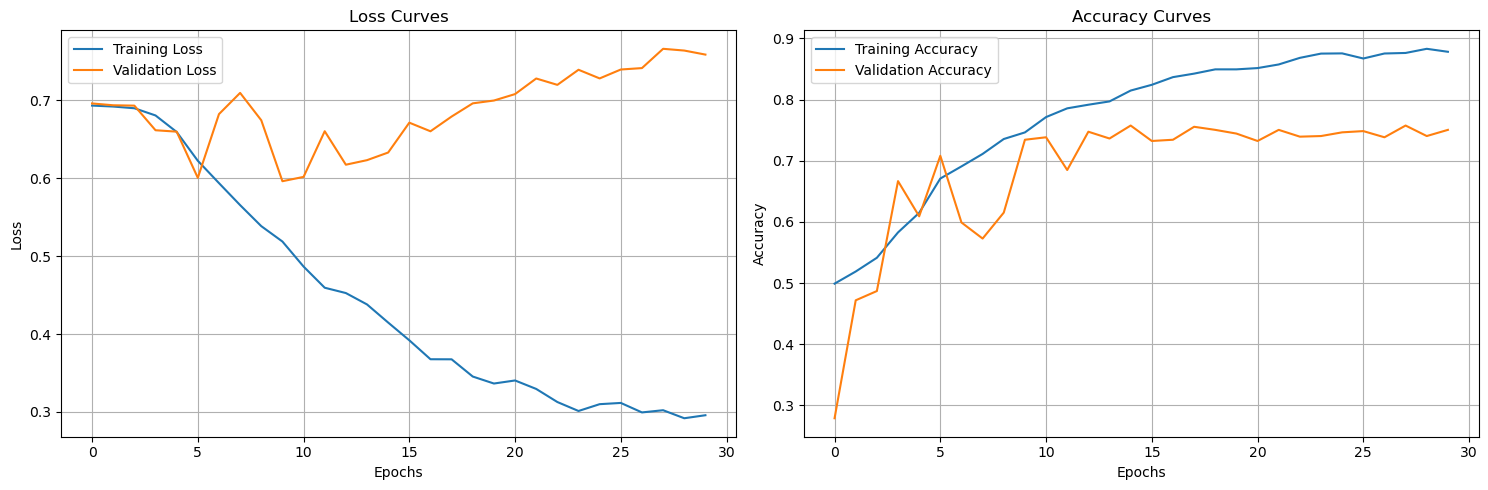

In [5]:
def plot_training_history(history):
    """
    Plot training history
    
    Args:
        history: Dictionary containing training history
    """
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curves')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training and validation accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('fnirs_training_history.png')
    plt.show()

# Example usage with the model previously defined
if __name__ == "__main__":
    from torch.utils.data import DataLoader, TensorDataset
    
    # Assume we have the model, criterion, optimizer, and scheduler from the previous code
    model, criterion, optimizer, scheduler, device = train_fnirs_model()
    
    np.random.seed(42)  # For reproducibility
    torch.manual_seed(42)
    
    dataloaders = {
        'train': train_loader,
        'val': test_loader  # Using test_loader for validation in this example
    }
    
    
    # Train the model
    trained_model, history = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=30,
        early_stopping_patience=50
    )
    
    # Evaluate on test set
    test_metrics = evaluate_model(trained_model, test_loader, criterion, device)
    
    # Plot training history
    plot_training_history(history)